# Exercises for Catalogs and Colors

## 1. Converting to Magnitudes

Write a function that takes a FITS table (a special 1-d `numpy.ndarray`, as we've discussed), a magnitude zeropoint ($m_0$), and a `dict` that maps the name of the filter to the name of a flux column, and returns a `dict` of arrays of magnitudes.  In other words, I should be able to call:

In [1]:
import astropy.io.fits
import numpy as np
fits = astropy.io.fits.open("../../data/HSC_grizy_example.fits")
table = fits[1].data

def getMagnitudes(table, magzero, fields):
    result = {}
    for k,v in fields.items():
        #do stuff with k and v
        result[k]=-2.5*np.log(table[v])/np.log(10)+magzero
    return result

def flux2mag(flux, magzero):
    return -2.5*np.log10(table[v])+magzero


In [2]:
mags = getMagnitudes(table, 1, {"r": "R_FLUX_KRON", "i": "I_FLUX_KRON"})
print mags
len(table)

{'i': array([-6.13310204, -1.32697388, -4.94322177, ..., -3.31956597,
       -4.02610846,         nan]), 'r': array([-6.3574845 , -1.642651  , -5.23862529, ..., -3.23657913,
       -4.89820009, -2.27296011])}


/Users/dennisyi/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: RuntimeWarning: invalid value encountered in log


4972

...and be able to say `mags["r"]` to get a `numpy.ndarray` of all the *r* magnitudes.

## 2. Filtering the catalog

Modify your function to only include rows where none of the magnitudes are NaN or infinite.  Some `numpy` functions you may want to look up and use:
 - `numpy.logical_and`
 - `numpy.isfinite` (note that this can also help check for NaNs)
Make sure each magnitude array your function returns is consistent (i.e. they all include the same rows).  So you can't just exclude the NaN $r$ magnitudes from the $r$ array, while leaving them in the $i$ array.

In [3]:
def getFilteredMagnitudes(table, magzero, fields):
    # Mask out rows with Nan entries from table
    mask = np.ones(len(table), dtype=bool)
    for v in fields.values():
        #submask = np.logical_and(np.isfinite(table[v]),table[v]>0)
        submask = np.isfinite(table[v])
        np.logical_and(submask,mask, out=mask)
    table = table[mask]
    
    # Mask out rows with negative fluxes
    # This is done after removing Nans so > doesn't encounter invalid values.
    mask = np.ones(len(table), dtype=bool)
    for v in fields.values():
        submask = table[v]>0
        np.logical_and(submask,mask, out=mask)
    table = table[mask]
    
    # Map fluxes to magnitudes according to requested fields
    result = {}
    for k,v in fields.items():
        result[k]=-2.5*np.log(table[v])/np.log(10)+magzero
        #submask = np.logical_not(np.isnan(table[k]))
    
    
    # The following secound-round cleaning is redundant with cleaning negative values, seen above
    #########
    #Make another mask; false for any row containing Nan 
    #mask = np.ones(len(result.values()[0]), dtype=bool)
    #for k in fields: # Let's figure out a way to mess with the arrays in place, vs to copy over
    #    submask = np.logical_not(np.isnan(result[k]))
    #    np.logical_and(submask,mask, out=mask)
    
    # Use the complete mask to clean each array in the dict
    #cleanmags = {}
    #for k in fields:
    #    result[k] = result[k][mask]
    
    
    return result

In [4]:
mags = getFilteredMagnitudes(table, 1, {"r": "R_FLUX_KRON", "i": "I_FLUX_KRON"})
print mags


{'i': array([-6.13310204, -1.32697388, -4.94322177, ..., -3.38842112,
       -3.31956597, -4.02610846]), 'r': array([-6.3574845 , -1.642651  , -5.23862529, ..., -3.86191174,
       -3.23657913, -4.89820009])}


In [5]:
# What fluxes are giving me Nan's in the logarithm?
print table['I_FLUX_KRON']
print """It's negative fluxes!
How does a measurement mechanism even end up with negative values for flux!?
In what sane world are such values allowed to be recorded in the catalogue!?"""

[ 713.24841364    8.52686827  238.3903694  ...,   53.43507061  102.43382339
   -3.36995924]
It's negative fluxes!
How does a measurement mechanism even end up with negative values for flux!?
In what sane world are such values allowed to be recorded in the catalogue!?


## 3. A Color-Color Plot

Make a plot of $g-r$ vs $i-z$, using your function to extract magnitudes from the catalog.  Use `27.0` for the magnitude zeropoint, and the `KRON` fluxes in the catalog.

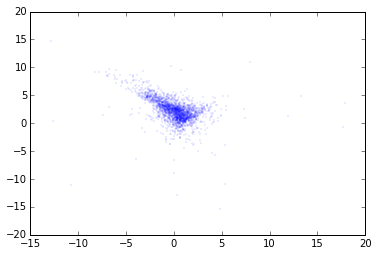

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
# Stolen directly from the reference example, since I didn't know about python's
# new string formatting syntax.
# This is a clever way of creating a dictionary
fields = {k: "{}_FLUX_KRON".format(k.upper()) for k in ("g", "r", "i", "z", "y")}
mags = getFilteredMagnitudes(table, 27.0, fields)

plt.scatter(mags['g']-mags['r'],mags['i']-mags['z'],s = 0.4,linewidth = 0)
plt.show()

## 4. A Color-Magnitude Plot

Make a plot of $r$ vs $g-r$.  This time use `PSF` fluxes from the catalog, again with `magzero=27.0`.

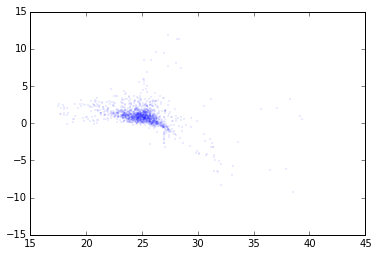

In [19]:
fields = {k: "{}_FLUX_PSF".format(k.upper()) for k in ("g", "r", "i", "z", "y")}
mags = getFilteredMagnitudes(table, 27.0, fields)

plt.scatter(mags['r'],mags['g']-mags['r'],s = 0.4,linewidth = 0)
plt.show()

## 5. High-Dimensional Plotting

We have 5 different filters, so we'd really like to plot a 5-dimensional space.  Since the magnitudes are relatively similar for a single object, we're best off plotting one magnitude against four colors.

Of course, a single scatter plot can only plot two dimensions at once, so we'll have to be creative to visualize them all at once.  Some things we could consider:
 - Using different colors or different markers for different axes.
 - A grid of scatter plots, where each row has the same y-axis and each column has the same x-axis.
 - 3-d plots.
 
Matplotlib can do all of these, and you can find lots of examples to start from here: http://matplotlib.org/gallery.html

Do some experimentation (or some educated guessing) and try to find a plot (or set of related plots) that lets you see the most structure in our 5-dimensional space - imagine that we're trying to identify different populations of objects based on their magnitudes in different filters.  You don't have to try all of the kinds of plots above, and you don't even have to use all of the magnitudes - if you can make a case that most of the information in one magnitude (or color) is redundant with another one that you are including (so ideally, if you choose not to include one magnitude in your favorite plots, you should have another plot that shows why you think it's not very helpful).

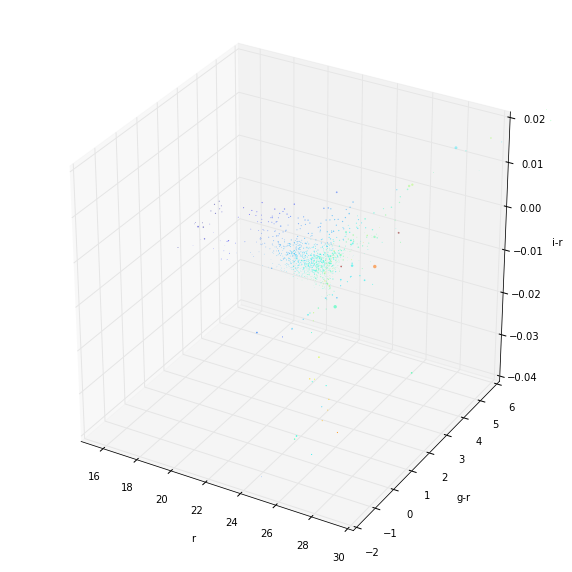

In [57]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(mags['r'],mags['g']-mags['r'],mags['i']-mags['r'],c = mags['z'], linewidth = 0)

ax.set_xlabel('r')
ax.set_ylabel('g-r')
ax.set_zlabel('i-r')

ax.set_xlim3d(15, 30)
ax.set_ylim3d(-2, 6)
ax.set_zlim3d(-0.04, 0.02)

plt.show()
